In [1]:
import pandas as pd
import os
##########################################################################################################################################################################################
# # 1 数据整理

# ## 1.1导入数据

# In[2]:
os.chdir(".//")
loanfile = os.listdir()
createVar = locals()
for i in loanfile:
    if i.endswith("csv"):        
        createVar['t_'+ i.split('.')[0]] = pd.read_csv(i, encoding = 'gbk')
        print(i.split('.')[0])


# ## 1.2、生成被解释变量bad_good
        
# In[3]:

bad_good = {'B':1, 'D':1, 'A':0, 'C': 2}
t_loans['bad_good'] = t_loans.status.map(bad_good) 
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html

t_loans.head()

# ## 1.3、借款人的年龄、性别

# In[4]:

data2 = pd.merge(t_loans, t_disp, on = 'account_id', how = 'left') # ‘left’, ‘right’, ‘outer’, ‘inner’
data2 = pd.merge(data2, t_clients, on = 'client_id', how = 'left')
data2=data2[data2.type=='所有者']

data2.head()
# ## 1.4、借款人居住地的经济状况

# In[5]:

data3 = pd.merge(data2, t_district, left_on = 'district_id', right_on = 'A1', how = 'left')
data3.head()

# ## 1.5、贷款前一年内的账户平均余额、余额的标准差、变异系数、平均收入和平均支出的比例

# In[6]:

data_4temp1 = pd.merge(t_loans[['account_id', 'date']],
                       t_trans[['account_id','type','amount','balance','date']],
                       on = 'account_id')
data_4temp1.columns = ['account_id', 'date', 'type', 'amount', 'balance', 't_date']
data_4temp1 = data_4temp1.sort_values(by = ['account_id','t_date'])

data_4temp1['date']=pd.to_datetime(data_4temp1['date'])
data_4temp1['t_date']=pd.to_datetime(data_4temp1['t_date'])
data_4temp1.tail()

# ## 将对账户余额进行清洗
# In[9]:

data_4temp1['balance2'] = data_4temp1['balance'].map(
    lambda x: int(''.join(x[1:].split(','))))
data_4temp1['amount2'] = data_4temp1['amount'].map(
    lambda x: int(''.join(x[1:].split(','))))

data_4temp1.head()

# ## 根据取数窗口提取交易数据--选取贷款放款日之前一年的交易信息！
# In[10]:

import datetime
data_4temp2 = data_4temp1[data_4temp1.date>data_4temp1.t_date][
    data_4temp1.date<data_4temp1.t_date+datetime.timedelta(days=365)]
data_4temp2.tail()

# ### 1.5.1账户平均余额、余额的标准差、变异系数

# In[11]:

data_4temp3 = data_4temp2.groupby('account_id')['balance2'].agg([('avg_balance','mean'), ('stdev_balance','std')])
data_4temp3['cv_balance'] = data_4temp3[['avg_balance','stdev_balance']].apply(lambda x: x[1]/x[0],axis = 1)
#https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.Series.apply.html

data_4temp3['cv_balance2'] = data_4temp3['stdev_balance'] / data_4temp3['avg_balance']

data_4temp3.head()

# ### 1.5.2 平均支出和平均收入的比例
# In[12]:

type_dict = {'借':'out','贷':'income'}
data_4temp2['type1'] = data_4temp2.type.map(type_dict)
data_4temp4 = data_4temp2.groupby(['account_id','type1'])[['amount2']].sum()
data_4temp4.head()


# In[13]:

data_4temp5 = pd.pivot_table(
    data_4temp4, values = 'amount2', 
    index = 'account_id', columns = 'type1')
# https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.pivot_table.html

data_4temp5.fillna(0, inplace = True)
data_4temp5['r_out_in'] = data_4temp5[
    ['out','income']].apply(lambda x: x[0]/x[1], axis = 1)
data_4temp5.head()


# In[14]:

data4 = pd.merge(data3, data_4temp3, left_on='account_id', right_index= True, how = 'left')
data4 = pd.merge(data4, data_4temp5, left_on='account_id', right_index= True, how = 'left')

data4.head()
# ## 1.6、计算贷存比，贷收比

# In[15]:

data4['r_lb'] = data4[['amount','avg_balance']].apply(lambda x: x[0]/x[1],axis = 1)
data4['r_lincome'] = data4[['amount','income']].apply(lambda x: x[0]/x[1],axis = 1)

data4.head()
# In[17]:
##########################################################################################################################################################################################
# # 2 构建Logistic模型
data4.columns
# •提取状态为C的用于预测。其它样本随机抽样，建立训练集与测试集

# In[17]:

data_model=data4[data4.status!='C']
for_predict=data4[data4.status=='C']

# 利用sample划分
train = data_model.sample(frac=0.7, random_state=1235).copy()
test = data_model[~ data_model.index.isin(train.index)].copy()
print(' 训练集样本量: %i \n 测试集样本量: %i' %(len(train), len(test)))

candidates = ['bad_good', 'A1', 'GDP', 'A4', 'A10', 'A11', 'A12','amount', 'duration',
       'A13', 'A14', 'A15', 'a16', 'avg_balance', 'stdev_balance',
       'cv_balance', 'income', 'out', 'r_out_in', 'r_lb', 'r_lincome']
data_for_select = train[candidates]


district
clients
accounts
loans


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


trans
card
order
disp


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


 训练集样本量: 195 
 测试集样本量: 84


# 向前

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 过滤式特征选择---前向选择(forward selection)和后向淘汰(backward elimination)
def forward_select(data, response):

    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')
    while remaining:
        aic_with_candidates=[]
        for candidate in remaining:
            formula = "{} ~ {}".format(
                response,' + '.join(selected + [candidate]))
            aic = smf.glm(
                formula=formula, data=data, 
                family=sm.families.Binomial(sm.families.links.logit)
            ).fit().aic
            aic_with_candidates.append((aic, candidate))
        aic_with_candidates.sort(reverse=True)
        best_new_score, best_candidate=aic_with_candidates.pop()
        if current_score > best_new_score: 
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            print ('aic is {},continuing!'.format(current_score))
        else:        
            print ('forward selection over!')
            break
            
    formula = "{} ~ {} ".format(response,' + '.join(selected))
    print('final formula is {}'.format(formula))
    model = smf.glm(
        formula=formula, data=data, 
        family=sm.families.Binomial(sm.families.links.logit)
    ).fit()
    return(model)

aic is 167.43311432504638,continuing!
aic is 135.8243585604184,continuing!
forward selection over!
final formula is bad_good ~ r_lb + cv_balance 


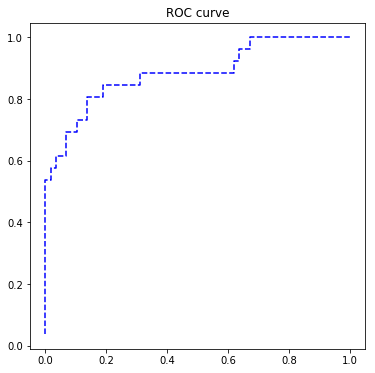

AUC = 0.8846


In [3]:
lg_m1 = forward_select(data=data_for_select, response='bad_good')
lg_m1.summary().tables[1]

# In[24]:

import sklearn.metrics as metrics
import matplotlib.pyplot as plt
fpr, tpr, th = metrics.roc_curve(test.bad_good, lg_m1.predict(test))
plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, 'b--')
plt.title('ROC curve')
plt.show()


# In[25]:

print('AUC = %.4f' %metrics.auc(fpr, tpr))

In [4]:
family=sm.families.Binomial(sm.families.links.logit)

# sklearn

In [75]:
from sklearn.model_selection import train_test_split

dataUse1  = data_model[candidates].copy()
del dataUse1['bad_good']
dataUse1.fillna(0, inplace=True)
y = data_model['bad_good']



In [88]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

dataUse = scale(dataUse1)
#dataUse = StandardScalr().fit_transform(dataUse1)

In [160]:
dataUse = dataUse1

In [161]:
train_X, test_X, train_y, test_y = train_test_split(dataUse, y, test_size=0.3, random_state=12)
#### 分开X,y---train
#cols = data_model.columns.values
#X = data_model[ cols[(cols!='bad_good')&(cols!='date')&(cols!='birth_date')&(cols!='sex')&(cols!='type')&(cols!='status')] ]
# X = data_model[candidates]
# X.fillna(0, inplace=True)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1235)

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [162]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((195, 20), (195,), (84, 20), (84,))

In [92]:
train_X

array([[-0.62966992, -0.52353495, -0.59566612, ...,  1.36717573,
         0.63332892,  0.16144391],
       [ 0.6696064 , -0.29411519, -0.32262971, ..., -0.29427561,
        -0.4713176 , -0.25668922],
       [-0.86590197, -0.51012671, -0.49731799, ...,  1.19101939,
         0.04159052, -0.08416051],
       ...,
       [-0.94464599, -0.23933007, -0.26548809, ..., -0.02675228,
         0.33244648, -0.1089618 ],
       [ 0.59086238, -0.46255967, -0.45862201, ...,  0.33143526,
        -0.43228733, -0.24948395],
       [ 1.18144252, -0.29396834, -0.12387409, ...,  0.05317537,
        -0.02580423,  0.02382534]])

In [166]:
#%%
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

%matplotlib inline

# Create the RFE object and compute a cross-validated score.
#model = SVC(kernel="linear")
model = LogisticRegression()
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=model, step=1, cv=5, #StratifiedKFold(y, 2),
              scoring='accuracy') #'accuracy, roc_auc


In [167]:
rfecv

RFECV(cv=5,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

In [168]:
rfecv.fit(train_X, train_y)

RFECV(cv=5,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

Optimal number of features : 13


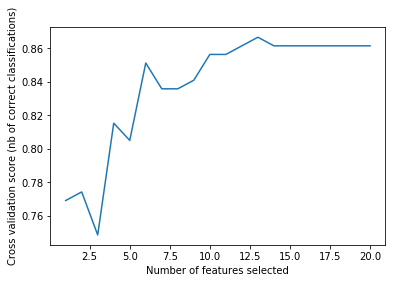

In [170]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [171]:
rfecv.ranking_

array([1, 1, 1, 1, 1, 4, 1, 1, 3, 1, 5, 1, 1, 1, 8, 7, 1, 6, 1, 2])

In [172]:
rfecv.support_

array([ True,  True,  True,  True,  True, False,  True,  True, False,
        True, False,  True,  True,  True, False, False,  True, False,
        True, False])

In [173]:
rfecv.n_features_, rfecv.grid_scores_

(13, array([0.76923077, 0.77435897, 0.74871795, 0.81538462, 0.80512821,
        0.85128205, 0.83589744, 0.83589744, 0.84102564, 0.85641026,
        0.85641026, 0.86153846, 0.86666667, 0.86153846, 0.86153846,
        0.86153846, 0.86153846, 0.86153846, 0.86153846, 0.86153846]))

In [174]:
rfecv.score(train_X, train_y)

0.8615384615384616

In [175]:
rfecv.score(test_X, test_y)

0.8333333333333334

In [150]:
dataUse1.columns

Index(['A1', 'GDP', 'A4', 'A10', 'A11', 'A12', 'amount', 'duration', 'A13',
       'A14', 'A15', 'a16', 'avg_balance', 'stdev_balance', 'cv_balance',
       'income', 'out', 'r_out_in', 'r_lb', 'r_lincome'],
      dtype='object')